# Computational modeling : RL algorithms in a virtual environment

Question : under very low amounts of evidence, how do human sample a complex action space ? Can we infer some form of structure in this exploration ? Can Active Inference provide some answers regarding the mechanistic processes behind it ?



First, we grab the data corresponding to the experiment we're interested in (here, experiment 002). We also remove the subjects that either had technical issues or had very suspicious results. *(we should provide a clear rule on subject exclusion here, maybe based on action variance across all dimensions or reaction times ?).*

In [1]:
# Import the needed packages 
# 
# 1/ the usual suspects
import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp

from jax.tree_util import tree_map
import jax.random as jr
import tensorflow_probability.substrates.jax.distributions as tfd 

# 2/ Useful functions from our package :
from actynf.jaxtynf.jax_toolbox import _normalize,_jaxlog
from actynf.jaxtynf.jax_toolbox import random_split_like_tree



# To make nice plots : 
from simulate.plot_trajectory import plot_training


# The simulated environment :
from simulate.hmm_weights import behavioural_process # The environment is statically defined by its HMM matrices
from simulate.generate_observations_full_actions import TrainingEnvironment,run_loop,generate_synthetic_data

# The methods to predict actions, compute the log-likelihoods and fit the models :
from simulate.compute_likelihood_full_actions import compute_predicted_actions,compute_loglikelihood
from simulate.compute_likelihood_full_actions import fit_mle_agent,fit_map_agent
from functools import partial


# The artificial agents : 
from agents_no_ck_mixed_actions import simple_ltQL_agent

# We will need a random model to evaluate the goodness of our predictions ! 
from agents_no_ck import random_agent


c:\Users\annic\OneDrive\Bureau\MainPhD\code\behavioural_exp_code\exploit_results_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
NTRIALS = 10
T = 11

# MODEL CONSTANTS :
N_LATENT_STATES = 5

# ENVIRONMENTAL CONSTANTS :
N_FEEDBACK_OUTCOMES = 6
TRUE_FEEDBACK_STD =  0.175#0.025
GRID_SIZE = (7,7)
START_COORD = [[5,1],[5,2],[4,1]]
END_COORD = [0,6]

# The weights of the HMM environment
(a,b,c,d,e,u),fb_vals = behavioural_process(GRID_SIZE,START_COORD,END_COORD,N_FEEDBACK_OUTCOMES,TRUE_FEEDBACK_STD)

rngkey = jax.random.PRNGKey(np.random.randint(0,10))
ENVIRONMENT = TrainingEnvironment(rngkey,a,b,c,d,e,u,T)

No = N_FEEDBACK_OUTCOMES
Ns = N_LATENT_STATES

# Depending on the dimensions of the problem :
models_constants = {
    "position" : {
        "N_actions" : 9,
        "N_outcomes" : No,
        "N_states" : Ns
    },
    "angle" : {
        "N_actions" : 9,
        "N_outcomes" : No,
        "N_states" : Ns
    },
    "distance" : {
        "N_actions" : 4,
        "N_outcomes" : No,
        "N_states" : Ns
    },
    
}
my_agent = partial(simple_ltQL_agent,constants= models_constants,focused_attention=True)

Behaviour of one static biais agent with uniform biais :

Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9
Trial 10
Trial 11
Trial 12
Trial 13
Trial 14
Trial 15
Trial 16
Trial 17
Trial 18
Trial 19


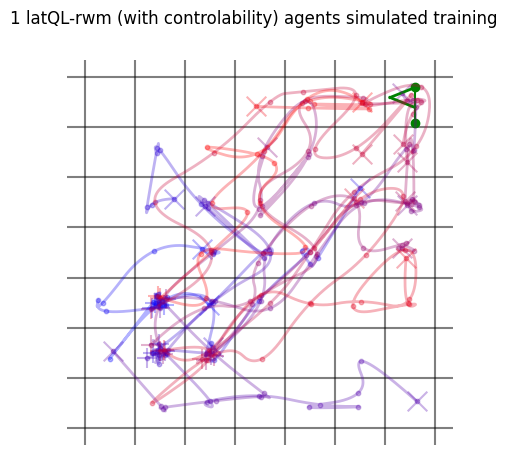

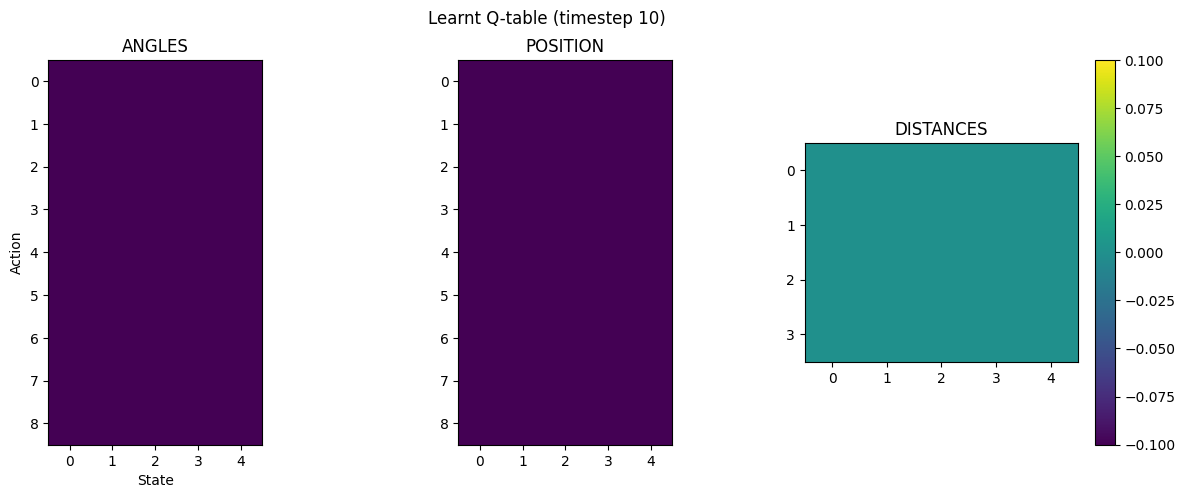

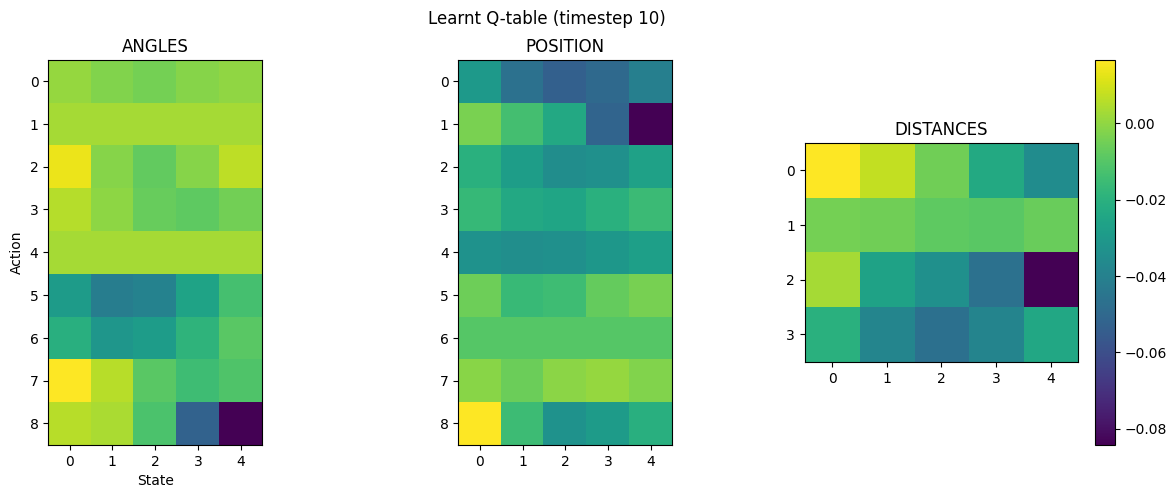

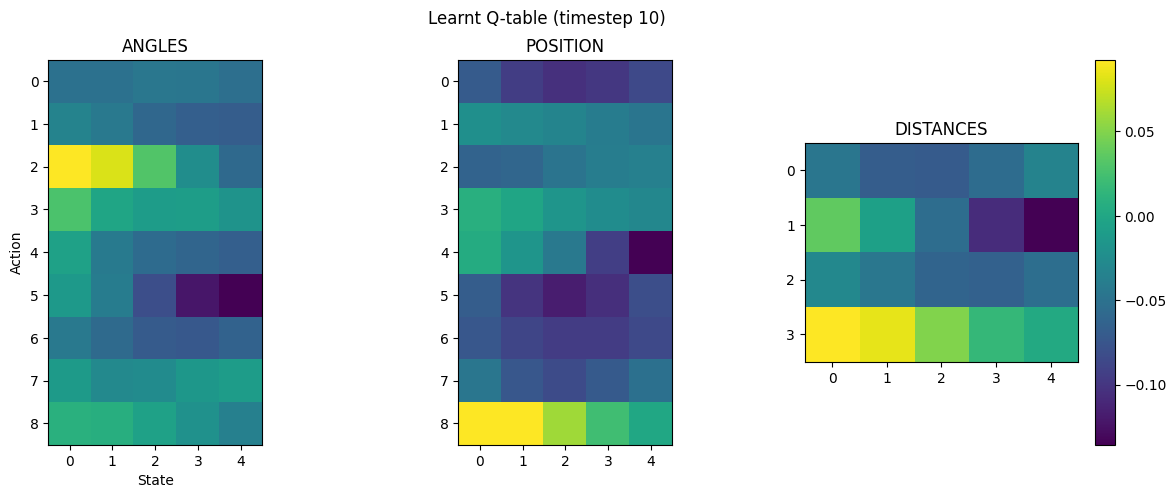

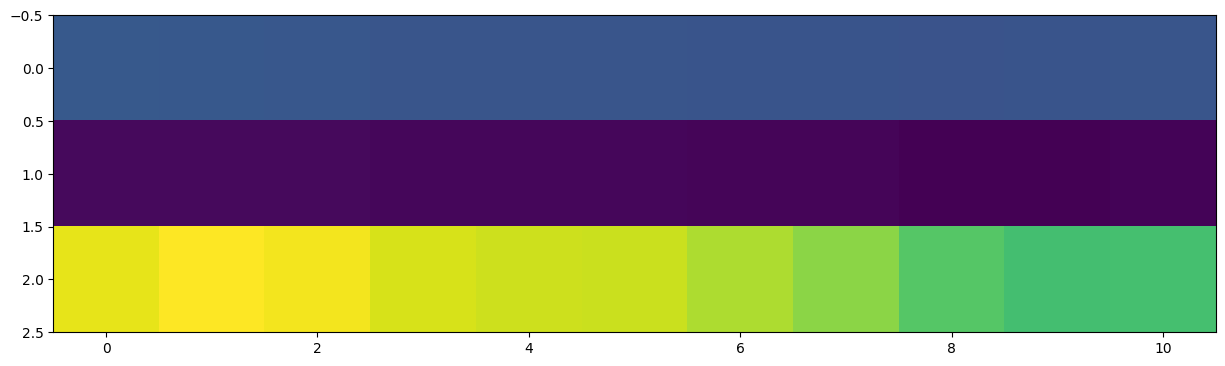

In [3]:
NTRIALS = 20
T = 11
test_run_hparams = {
    "alpha_omega": 0.3,
    "beta_omega" : 100.0,
    "alpha_Q":0.3,
    "beta_Q" :100.0,
    "beta_biais" : 5.0,
    "transition_alpha" : 0.3,
    "perception_sigma" : 0.25,
    "gamma_generalize" : 0.7,
    "position":{
        "biais":_normalize(jnp.array([0.0,0.1,0.2,0.1,0.8,0.1,0.0,0.0,0.0]))[0],
    },
    "angle":{
        "biais":_normalize(jnp.array([0.2,0.1,0.2,0.1,0.1,0.1,0.2,0.1,0.1]))[0],
    },
    "distance":{
        "biais":_normalize(jnp.array([0.3,0.3,0.1,0.3]))[0],
    },
}


SEED = np.random.randint(1000)
params_final,training_hist = run_loop(ENVIRONMENT,my_agent(test_run_hparams),SEED,NTRIALS)
simulated_states = np.array(training_hist["env_states"])

fig,ax = plt.subplots(figsize= (5,5))
fig.suptitle("1 latQL-rwm (with controlability) agents simulated training")
plot_training(ax,simulated_states,GRID_SIZE,END_COORD,line_width=2,alpha=0.3)


for trial in [0,5,-1]:
    (new_qt,omegas,bs,actions,posteriors) = training_hist["states"][trial]
    # print(np.stack(new_qt["angle"]).shape)
        
    t = 10
    
    
    fig,axs = plt.subplots(1,3,figsize=(15,5))
    fig.suptitle("Learnt Q-table (timestep {})".format(t))
    
    ax = axs[0]
    one_training_episode_qtables = np.stack(new_qt["angle"][trial])
    im = ax.imshow(one_training_episode_qtables,cmap="viridis",vmin=np.min(one_training_episode_qtables),vmax=np.max(one_training_episode_qtables))
    ax.set_xlabel("State")
    ax.set_ylabel("Action")
    ax.set_title("ANGLES")
    
    ax = axs[1]
    one_training_episode_qtables = np.stack(new_qt["position"][trial])
    im = ax.imshow(one_training_episode_qtables,cmap="viridis",vmin=np.min(one_training_episode_qtables),vmax=np.max(one_training_episode_qtables))
    ax.set_title("POSITION")
    
    ax = axs[2]
    one_training_episode_qtables = np.stack(new_qt["distance"][trial])
    im = ax.imshow(one_training_episode_qtables,cmap="viridis",vmin=np.min(one_training_episode_qtables),vmax=np.max(one_training_episode_qtables))
    ax.set_title("DISTANCES")
    
    fig.colorbar(im)


# print(training_hist["states"][1][0])
# print(training_hist["states"][1][1])
fig,ax = plt.subplots(figsize=(15,5))
# print(np.stack(omegas))

ax.imshow(np.stack(omegas).T)

Example of behaviour simulated by a given model in the environment :

Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9
Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9
Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9
Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9
Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9
Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9
Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9
Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9
Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9


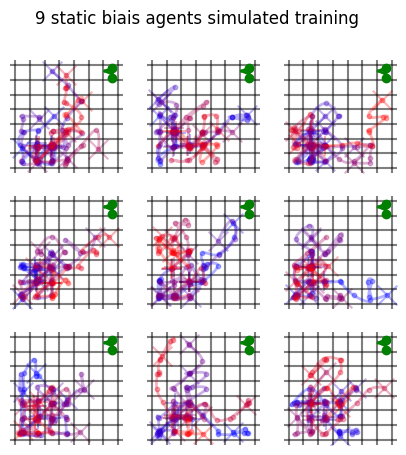

In [ ]:
# We can encode static biases for a specific action modality using this model. The global temperature parameter
# beta indicates how likley the agent is to shift focus !

NTRIALS = 10
fig,axs = plt.subplots(3,3,sharex=True,sharey=True,figsize= (5,5))
fig.suptitle("9 static biais agents simulated training")

test_run_hparams = {
    "alpha_omega": 0.3,
    "beta_omega" : 100.0,
    "alpha_Q":0.3,
    "beta_Q" :20.0,
    "beta_biais" : 5.0,
    "transition_alpha" : 0.3,
    "perception_sigma" : 0.25,
    "gamma_generalize" : 0.7,
    "position":{
        "biais":_normalize(jnp.array([0.0,0.1,0.2,0.1,0.8,0.1,0.0,0.0,0.0]))[0],
    },
    "angle":{
        "biais":_normalize(jnp.array([0.2,0.1,0.2,0.1,0.1,0.1,0.2,0.1,0.1]))[0],
    },
    "distance":{
        "biais":_normalize(jnp.array([0.3,0.3,0.1,0.3]))[0],
    },
}

for ax in axs.reshape(-1): 
    # In : an agent based on some hyperparameters : 
    SEED = np.random.randint(1000)

    params_final,training_hist = run_loop(ENVIRONMENT,my_agent(test_run_hparams),SEED,NTRIALS)

    simulated_states = np.array(training_hist["env_states"])

    plot_training(ax,simulated_states,GRID_SIZE,END_COORD,line_width=2,alpha=0.3)


Generate some synthetic data for the model we're interested in, for the purpose of inverting it !

Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9
{'position': Array([[[0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0.]],

       [[0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0., 0.

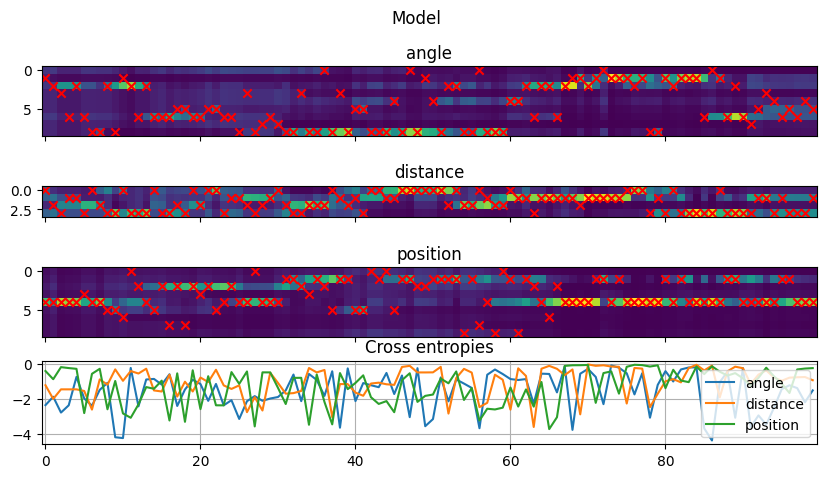

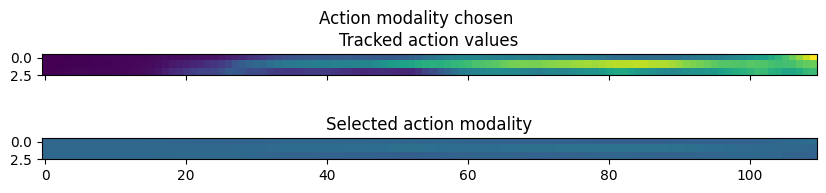

In [9]:
ground_truth_hparams = {
    "alpha_omega": 0.3,
    "beta_omega" : 100.0,
    "alpha_Q":0.3,
    "beta_Q" :100.0,
    "beta_biais" : 5.0,
    "transition_alpha" : 0.3,
    "perception_sigma" : 0.25,
    "gamma_generalize" : 0.7,
    "position":{
        "biais":_normalize(jnp.array([0.0,0.1,0.2,0.1,0.8,0.1,0.0,0.0,0.0]))[0],
    },
    "angle":{
        "biais":_normalize(jnp.array([0.2,0.1,0.2,0.1,0.1,0.1,0.2,0.1,0.1]))[0],
    },
    "distance":{
        "biais":_normalize(jnp.array([0.3,0.3,0.1,0.3]))[0],
    },
}
n_trials = 10
SYNTHETIC_DATA = generate_synthetic_data(ENVIRONMENT,my_agent(ground_truth_hparams),
                                         n_trials=n_trials,seed = 0,verbose = True)
(formatted_stimuli,bool_stimuli,rewards,true_actions,tmtsp) = SYNTHETIC_DATA


print(true_actions)

# Optimal likelihood for the data (the best predictive power we should be able to achieve ):
lls,ces = compute_loglikelihood(SYNTHETIC_DATA,my_agent(ground_truth_hparams),"sum")
final_parameters,predicted_actions,state_history = compute_predicted_actions(SYNTHETIC_DATA,my_agent(ground_truth_hparams))
model_states,other_data = state_history

# plt.imshow(np.reshape(ck_history["position"],(-1,9)))
fig,axs = plt.subplots(len(true_actions)+1,1,figsize=(n_trials,5),sharex=True)
fig.suptitle("Model")

for i,key in enumerate(predicted_actions.keys()):
    ax = axs[i]

    N_action_cat = true_actions[key].shape[-1]
    
    prediction_map = np.reshape(predicted_actions[key],(-1,N_action_cat))
    ax.set_title(key)    
    ax.imshow(prediction_map.T)
        
    N_timesteps  = prediction_map.shape[0]
    ax.scatter(np.arange(N_timesteps),np.argmax(true_actions[key],axis=-1),color="red",marker="x")

ax = axs[-1]
ax.set_title("Cross entropies")
for mod,series in ces.items():
    ax.plot(series.flatten(),label=mod)
ax.legend()
ax.grid()

print("GT LL : ")
print(lls)


omega_values = model_states[1]
print(omega_values.shape)


# print(weight_array.shape)

fig,axs = plt.subplots(2,1,figsize=(n_trials,2),sharex=True)
fig.suptitle("Action modality chosen")
axs[0].set_title("Tracked action values")
axs[0].imshow(np.reshape(omega_values,(-1,3)).T)
axs[1].set_title("Selected action modality")
axs[1].imshow(jax.nn.softmax(ground_truth_hparams["beta_omega"]*np.reshape(omega_values,(-1,3)).T,axis=0),vmin=0,vmax=1)


step 0, loss: Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([ 578.9904 ,  577.13403,  643.7428 , 1385.4216 ,  583.2861 ,
       1223.4614 ,  577.07916, 1123.1705 ,  678.93774,  590.388  ,
        594.41315,  606.1617 ,  639.9772 ,  584.38983,  669.7759 ,
        688.0714 ,  579.1355 ,  867.1396 , 1119.5713 ,  574.45233],      dtype=float32)
  batch_dim = 0
step 10, loss: Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([577.84045, 565.7627 , 548.48975, 657.49164, 575.2354 , 639.98364,
       570.5591 , 618.5973 , 559.74475, 524.73755, 580.0587 , 581.95844,
       583.62354, 578.69385, 558.7917 , 574.7051 , 572.13477, 581.71625,
       670.5851 , 566.2667 ], dtype=float32)
  batch_dim = 0
step 20, loss: Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([575.94214, 538.49243, 505.08453, 525.11554, 566.3965 , 593.49243,
       547.56744, 566.23456, 520.29956, 482.1233 , 575.84894, 567.375  ,
       571.1

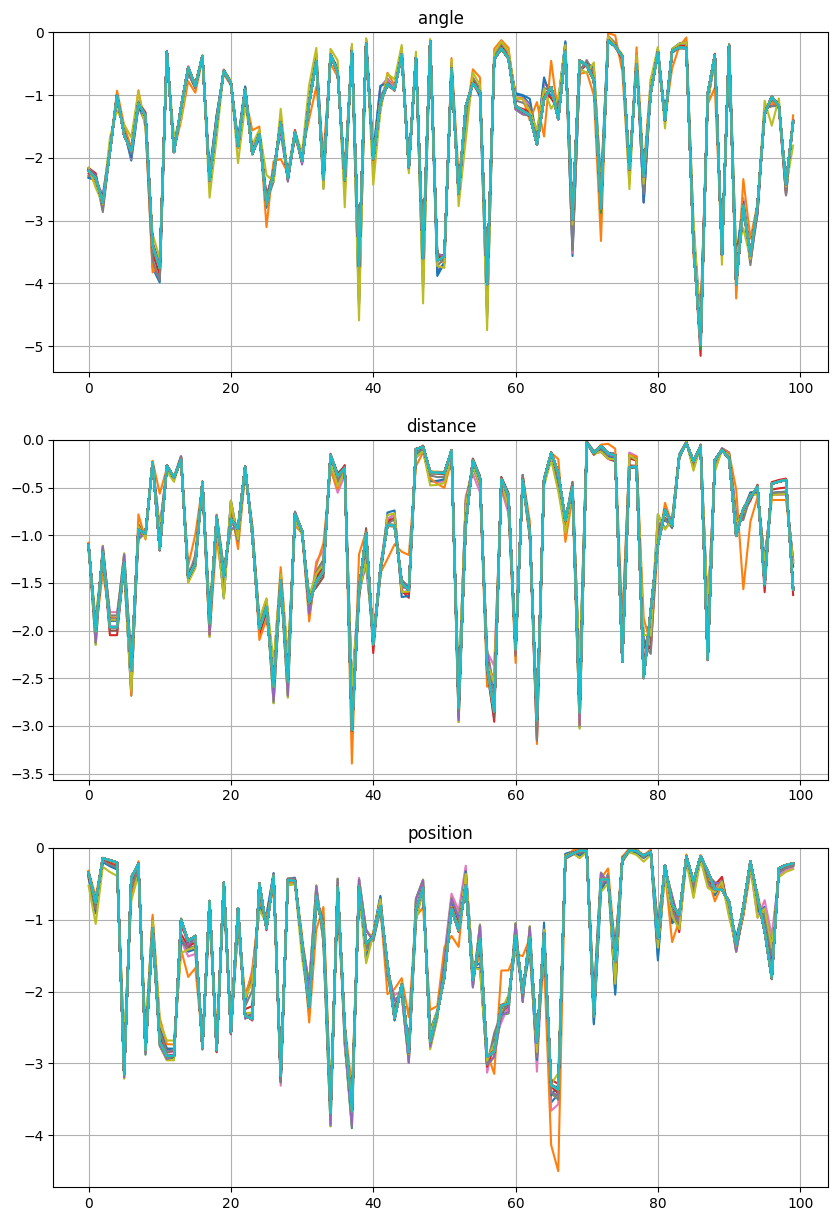

In [10]:
# Let's attempt the same, but using MAP fitting and ensuring the initial beta parameters are both quite high !
feature_range_tree = {
    "alpha_omega": jnp.array([-10,10]),
    "beta_omega" : jnp.array([-2,2]),
    "beta_biais" : jnp.array([-2,2]),
    "alpha_Q": jnp.array([-10,10]),
    "beta_Q" :jnp.array([-2,2]),
    "transition_alpha" : jnp.array([-10,10]),
    "perception_sigma" : jnp.array([-2,2]),
    "gamma_generalize" : jnp.array([-2,2]),
    "angle":{
        "biais":jnp.array([-10,10,9])
    },
    "position":{
        "biais":jnp.array([-10,10,9])
    },
    "distance":{
        "biais":jnp.array([-10,10,4])
    }
}


zero_one_uni = tfd.Uniform(low=-1e-5,high=1.0+1e-5)  # Bounds may be a bit finnicky
beta_val = 10
beta_std = 5.0
flat_uni = tfd.Uniform(low=-1e-5,high=1e6 +1e-5)


# Assuming uniform distributions for all initial parameter heads :
parameter_prior_tree ={
    "alpha_omega": zero_one_uni,
    "beta_omega": tfd.Normal(beta_val, beta_std),
    "beta_biais" : tfd.Normal(beta_val, beta_std),
    "alpha_Q" : zero_one_uni,
    "beta_Q" : tfd.Normal(beta_val, beta_std),
    
    "transition_alpha" : zero_one_uni,
    "perception_sigma" : flat_uni,
    "gamma_generalize" : flat_uni,
    
    "angle":{
        "biais" : zero_one_uni,  # No priors on the individual biaises !
    },
    "position":{
        "biais" : zero_one_uni,  # No priors on the individual biaises !
    },
    "distance":{
        "biais" : zero_one_uni,  # No priors on the individual biaises !
    }
}

# all_fin_params,(gt_mle,all_losses,all_param_histories),encoding_function = fit_map_agent(SYNTHETIC_DATA,
#                             my_agent,feature_range_tree,parameter_prior_tree,jax.random.PRNGKey(0),
#                             n_heads=20,num_steps=250,verbose=True,start_learning_rate=1e-1)

all_fin_params,(gt_mle,all_losses,all_param_histories),encoding_function = fit_mle_agent(SYNTHETIC_DATA,
                            my_agent,feature_range_tree,jax.random.PRNGKey(0),
                            n_heads=20,num_steps=250,verbose=True,start_learning_rate=1e-1)

final_lls,cross_entropies = jax.vmap(lambda x : compute_loglikelihood(SYNTHETIC_DATA,my_agent(encoding_function(x)),"sum"))(all_fin_params)


print(cross_entropies["angle"])
print(min(final_lls["angle"]))
print(max(final_lls["angle"]))
fig,axs = plt.subplots(3,1,figsize=(10,15))
for i,key in enumerate(cross_entropies.keys()):
    axs[i].set_title(key)
    for head in range(100):
        axs[i].plot(cross_entropies[key][head].flatten())
    axs[i].set_ylim(ymax=0.0)
    axs[i].grid()
plt.show()

Given the best match for subject parameters, we then reconstruct the evolution of model states / parameters across trials.

(20, 10, 11, 9, 5)
{'alpha_Q': Array([2.8395606e-02, 3.2409716e-01, 6.9407785e-01, 8.7485093e-01,
       7.2489393e-01, 9.9989891e-01, 8.9189482e-01, 9.0387487e-01,
       8.8653380e-01, 9.9999201e-01, 9.4990230e-01, 3.0187654e-01,
       3.6437064e-01, 9.7546625e-01, 9.9995041e-01, 2.9848441e-01,
       4.1206449e-01, 9.4840693e-01, 4.6149982e-04, 8.9838076e-01],      dtype=float32), 'alpha_omega': Array([5.1875589e-03, 4.7906259e-01, 7.0859158e-01, 6.7178982e-01,
       7.0683742e-01, 3.8879254e-01, 9.9866426e-01, 6.1692011e-01,
       6.8965226e-01, 2.9784635e-01, 6.8902177e-01, 2.7467243e-02,
       5.2851045e-01, 7.9215632e-04, 7.5353503e-01, 5.7873565e-01,
       6.0266060e-01, 6.7841148e-01, 9.9339044e-01, 7.0322001e-01],      dtype=float32), 'angle': {'biais': Array([[2.41719991e-01, 1.25459763e-07, 3.13271594e-04, 1.13593284e-02,
        5.03539286e-06, 1.60404921e-01, 3.56843472e-01, 1.66777402e-01,
        6.25765175e-02],
       [2.53524393e-01, 4.12676334e-02, 6.92096120e-

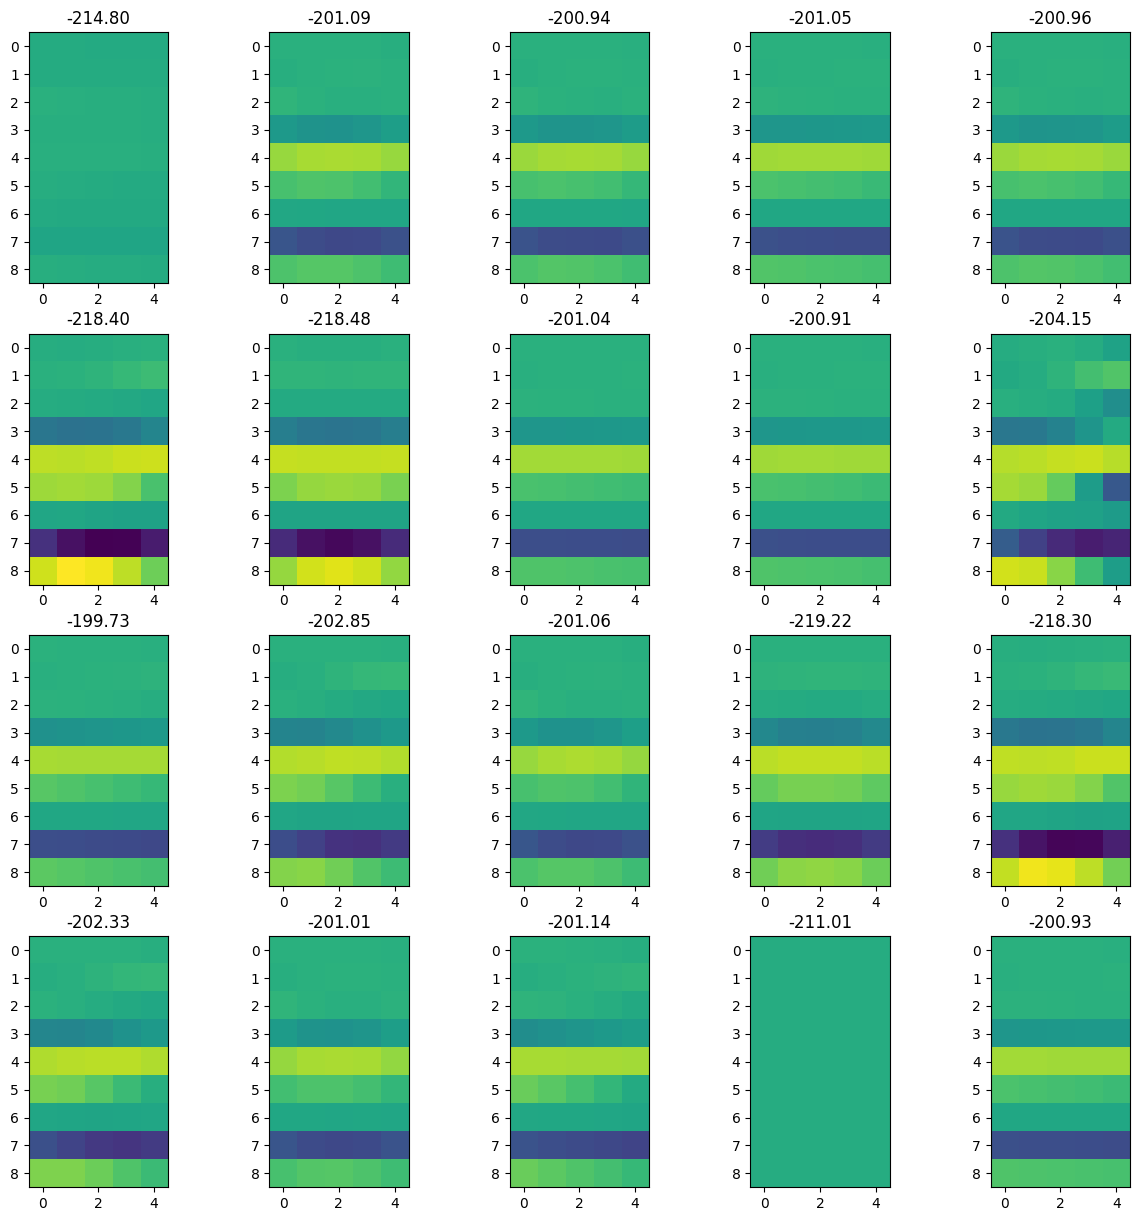

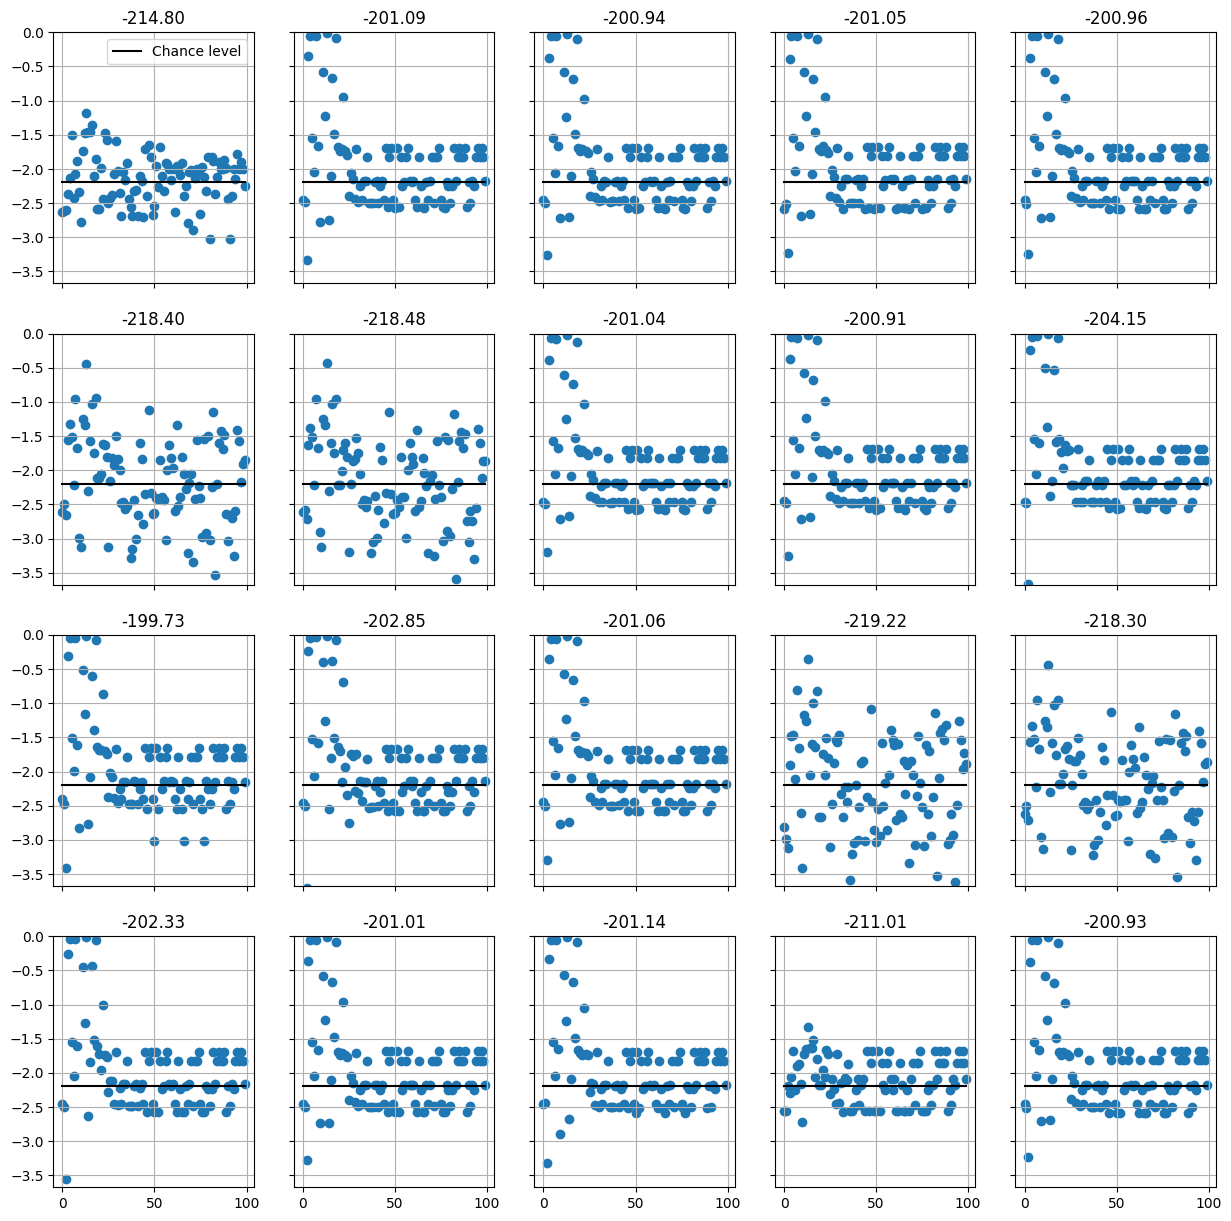

In [7]:
random_ll_term,random_predictions,random_model_variables  = jax.vmap(lambda x : compute_loglikelihood(SYNTHETIC_DATA,random_agent(encoding_function(x),models_constants),"sum",True))(all_fin_params)
random_logliks,random_cross_entropies = random_ll_term

ll_term,predictions,model_variables  = jax.vmap(lambda x : compute_loglikelihood(SYNTHETIC_DATA,my_agent(encoding_function(x)),"sum",True))(all_fin_params)
model_states,other_data = model_variables

logliks,cross_entropies = ll_term
qtable,omegas,Bs,_,posteriors = model_states



print(qtable["angle"].shape)  # N_heads x N_trials x N_timesteps x (Qtable)



optimal_params = jax.vmap(lambda x : encoding_function(x))(all_fin_params)
print(optimal_params)


fig,axs = plt.subplots(4,5,figsize=(15,15))

plot_this = np.stack([qtable["angle"][k,-1,-1,...] for k in range(qtable["angle"].shape[0])])
for k,ax in enumerate(axs.flatten()):
    ax.set_title("{:.2f}".format(float(logliks["angle"][k])))
    ax.imshow(plot_this[k,...],vmin = np.min(plot_this),vmax = np.max(plot_this))
plt.show()


ce_plots = np.reshape(cross_entropies["angle"],(cross_entropies["angle"].shape[0],-1))
random_ce_plots = np.reshape(random_cross_entropies["angle"],(random_cross_entropies["angle"].shape[0],-1))
fig,axs = plt.subplots(4,5,figsize=(15,15),sharex=True,sharey=True)
LOWER_EDGE = np.mean([np.min(ce_plots),np.min(random_ce_plots)])
for k,ax in enumerate(axs.flatten()):
    ax.scatter(np.arange(ce_plots[k].shape[0]),ce_plots[k])
    
    if k == 0:
        ax.plot(random_ce_plots[k],color="black",label="Chance level")
    else:
        ax.plot(random_ce_plots[k],color="black")
    ax.set_ylim([LOWER_EDGE,0])
    ax.grid()
    ax.set_title("{:.2f}".format(float(logliks["angle"][k])))

axs.flatten()[0].legend()
plt.show()


Let's try to probe how good our inversion is for this specific set of parameters :

{'alpha_omega': 0.5, 'beta_omega': 100.0, 'alpha_Q': 0.3, 'beta_Q': 100.0, 'beta_biais': 5.0, 'transition_alpha': 0.7, 'perception_sigma': 0.15, 'gamma_generalize': 0.1, 'position_biais': Array([0.        , 0.07692308, 0.15384616, 0.07692308, 0.61538464,
       0.07692308, 0.        , 0.        , 0.        ], dtype=float32), 'angle_biais': Array([0.16666666, 0.08333333, 0.16666666, 0.08333333, 0.08333333,
       0.08333333, 0.16666666, 0.08333333, 0.08333333], dtype=float32), 'distance_biais': Array([0.3, 0.3, 0.1, 0.3], dtype=float32)}


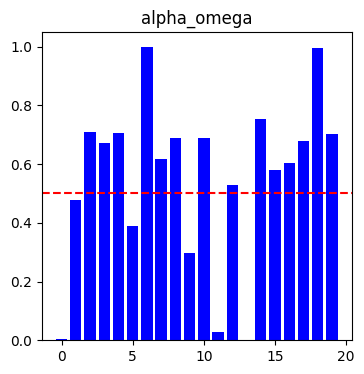

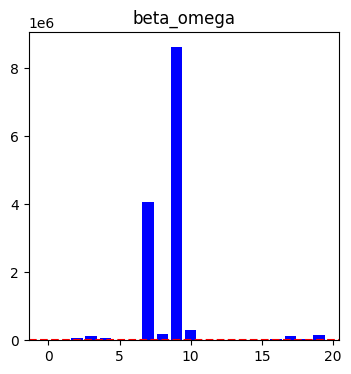

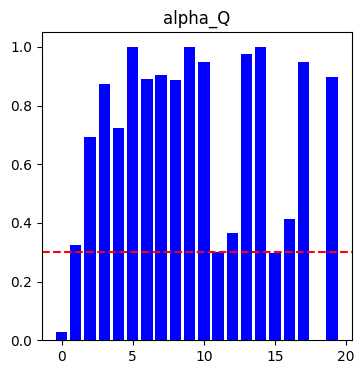

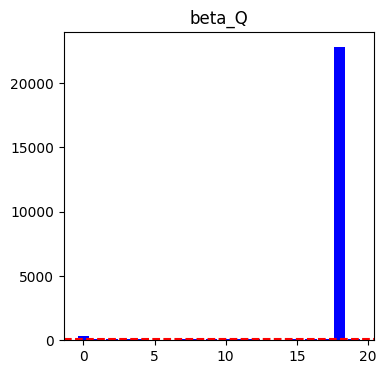

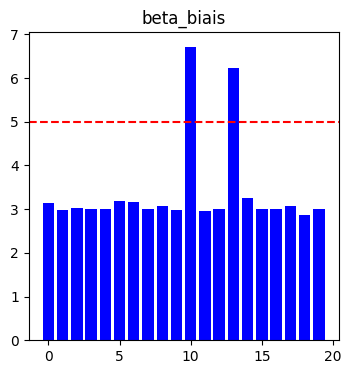

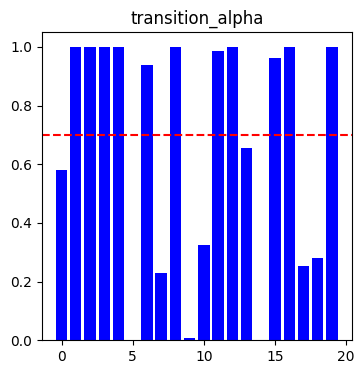

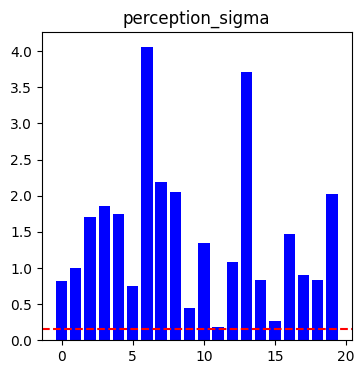

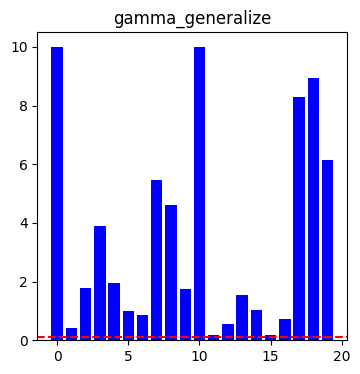

In [8]:
random_ll_term,random_predictions,random_model_variables  = jax.vmap(lambda x : compute_loglikelihood(SYNTHETIC_DATA,random_agent(encoding_function(x),models_constants),"sum",True))(all_fin_params)
random_logliks,random_cross_entropies = random_ll_term

ll_term,predictions,model_variables  = jax.vmap(lambda x : compute_loglikelihood(SYNTHETIC_DATA,my_agent(encoding_function(x)),"sum",True))(all_fin_params)
model_states,other_data = model_variables

logliks,cross_entropies = ll_term
qtable,omegas,Bs,_,posteriors = model_states





fitted_params = jax.vmap(lambda x : encoding_function(x))(all_fin_params)
# print(fitted_params["beta_omega"])
# print(ground_truth_hparams)

from collections.abc import MutableMapping
def flatten(dictionary, parent_key='', separator='_'):
    items = []
    for key, value in dictionary.items():
        new_key = parent_key + separator + key if parent_key else key
        if isinstance(value, MutableMapping):
            items.extend(flatten(value, new_key, separator=separator).items())
        else:
            items.append((new_key, value))
    return dict(items)

flat_gt = flatten(ground_truth_hparams)
flat_fit = flatten(fitted_params)

print(flat_gt)


key = "beta_Q"

for key,gtvalue in flat_gt.items():
    
    
    if type(gtvalue)==float:
        data_points = flat_fit[key]
        n_points = data_points.shape[0]
        
        fig,ax =  plt.subplots(figsize=(4,4))
        ax.set_title(key)
        ax.bar(range(n_points), data_points, color="blue", label="Data Points")
        ax.axhline(y=gtvalue, color="red", linestyle="--", label="Ground Truth")
    